# Burden Comparison Demo

In [1]:
import sys
sys.path.append('..')
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

## Set Constants

In [2]:
S = 1
click = 1
search = 4
AI = 1.5
QA = 3.5
RR = 4
constants = [S, click, search, AI, QA, RR]

TPR_d = 0.8
FPR_d = 0.03
P_sec_read = 0.05

## Load and Clean Data

In [3]:
data = pd.read_csv('../../data/namdinh.csv').fillna(0)

/Users/msanch35/Documents/6.871/mlhc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3229: DtypeWarning: Columns (27,33,61,65,69,71,81,82,103,104,106,107,113,114,116,117,120,132,133,134) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
drop = ['border', 
         'covid', 
         'fibrosis', 
         'pulmonary_scar', 
         'lung_opacity', 
         'airspace_opacity', 
         'other_findings', 
         'enlarged_cardiomediastinum']

### Merge Eqiuvalent Findings

In [5]:
data['opacity'] = data[['lung_opacity', 'airspace_opacity']].max(axis=1)
data['ai_opacity'] = data[['ai_lung_opacity', 'ai_airspace_opacity']].max(axis=1)

data['lung_scar'] = data[['fibrosis', 'pulmonary_scar']].max(axis=1)
data['ai_lung_scar'] = data[['ai_fibrosis', 'ai_pulmonary_scar']].max(axis=1)

### Set Clinically Significant Findings

In [6]:
findings = []
for i in list(data.columns):
    if 'ai_' == i[0:3]:
        add = True
        for j in drop:
            if j in i:
                add=False
        if add:    
            findings.append(i[3::])
            
sig_findings = [
    'cardiomegaly',
    'cavitation',
    'consolidation',
    'edema',
    #'enlarged_cardiomediastinum',
    'fracture',
    'lung_lesion',
    'opacity',
    'mass',
    'mass_nodule',
    'nodule',
    'pleural_effusion',
    'pneumonia',
    'pneumothorax',
    'tuberculosis',
    'widening_mediastinum'
]
non_sig_findings = [i for i in findings if i not in sig_findings]
non_sig_findings

['no_finding', 'atelectasis', 'pleural_other', 'medical_device', 'lung_scar']

Note, below, that the baseline burden is 29.6, which is approximately 30 seconds. 30 seconds was an approximate read time provided to us by radiologists.

In [7]:
np.sum(np.array(utils.pipeline_comparison_by_leaf_base(data, findings, constants,weighted=True))*21)

29.563575078058474

## Burden Ratio as a Function of Disagreement Model TPR

/Users/msanch35/Documents/6.871/RadAI_Usage/radAI/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


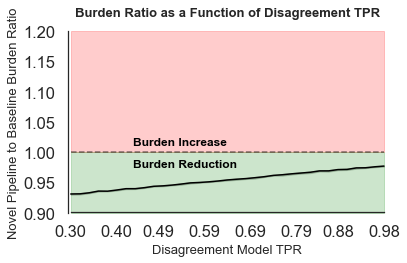

In [9]:
df_scores = utils.plot_Disagreement_sim_TPR_line(data, FPR_d, P_sec_read, findings, sig_findings, constants,
                                     TPR_ds = np.arange(0.3, 1, 0.02), 
                                     text=True, n_trials = 10, save_fig = True)

In our manuscript, we report burden ratios at the two ends of the plot to provide insight into the slope. These are computed with standard deviations below.

In [12]:
TPR_d_left = []
for i in range(10):
    TPR_d_left.append(utils.pipeline_comparison(data, 0.3, FPR_d, 0.05, findings, sig_findings, constants, print_it=False))
TPR_d_left = np.asarray(TPR_d_left)
print(TPR_d_left.mean(), TPR_d_left.std())

TPR_d_right = []
for i in range(10):
    TPR_d_right.append(utils.pipeline_comparison(data, 1, FPR_d, 0.05, findings, sig_findings, constants, print_it=False))
TPR_d_right = np.asarray(TPR_d_right)
print(TPR_d_right.mean(), TPR_d_right.std())

0.9311474115233457 0.0006780611405248384
0.978885739393135 0.0008943109116100429


In [26]:
print('reduction', (1-TPR_d_left.mean())*100, TPR_d_left.std()*100)
print('reduction', (1-TPR_d_right.mean())*100, TPR_d_right.std()*100)

reduction 6.8852588476654315 0.06780611405248384
reduction 2.1114260606865054 0.0894310911610043


## Burden Ratio as a Function of Disagreement Model FPR

/Users/msanch35/Documents/6.871/RadAI_Usage/radAI/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


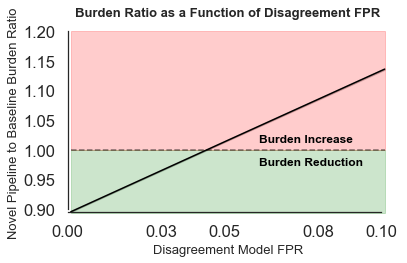

In [9]:
utils.plot_Disagreement_sim_FPR_line(data, TPR_d, P_sec_read, findings, sig_findings, constants,
                                     FPR_ds = np.arange(0.001, 0.12, 0.05), 
                                     text=True, n_trials = 10, save_fig = True)

Again, to put the slope into perspective, we provide burden ratio values for FPR of 0.01 and 0.1 along with their standard deviations

In [13]:
FPR_d_left = []
for i in range(10):
    FPR_d_left.append(utils.pipeline_comparison(data, TPR_d, 0.01, 0.05, findings, sig_findings, constants, print_it=False))
FPR_d_left = np.asarray(FPR_d_left)
print(FPR_d_left.mean(), FPR_d_left.std())

FPR_d_right = []
for i in range(10):
    FPR_d_right.append(utils.pipeline_comparison(data, TPR_d, 0.1, 0.05, findings, sig_findings, constants, print_it=False))
FPR_d_right = np.asarray(FPR_d_right)
print(FPR_d_right.mean(), FPR_d_right.std())

0.9171973109616454 0.0007539553170479219
1.1338677021357388 0.0017783628952511073


In [27]:
print('reduction', (1-FPR_d_left.mean())*100, FPR_d_left.std()*100)
print('increase', (FPR_d_right.mean()-1)*100, FPR_d_right.std()*100)

reduction 8.280268903835463 0.0753955317047922
increase 13.386770213573884 0.17783628952511074


## Burden Ratio as a Function of Second Reader Request Percentage

/Users/msanch35/Documents/6.871/RadAI_Usage/radAI/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


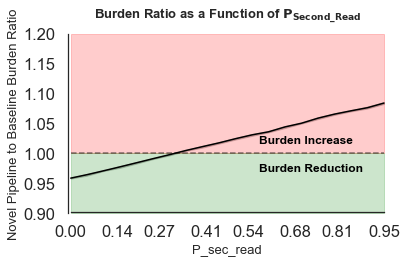

In [10]:
utils.plot_Disagreement_sim_Pred_Qual_line(data, TPR_d, FPR_d, findings, sig_findings, constants,
                                           P_sec_reads = np.arange(0, 1, 0.05),
                                           text=True, n_trials = 10, save_fig = True)

In the manuscript, we provide values for burden ratio when $P_{sec\_read}$ is 0.05 and 1.

In [14]:
P_sec_all = []
for i in range(10):
    P_sec_all.append(utils.pipeline_comparison(data, TPR_d, FPR_d, 1, findings, sig_findings, constants, print_it=False))
P_sec_all = np.asarray(P_sec_all)
print(P_sec_all.mean(), P_sec_all.std())

1.0911337680645612 0.0011233202922176198


In [ ]:
print('increase', (P_sec_all.mean()-1)*100, P_sec_all.std()*100)

In [10]:
P_sec_5 = []
for i in range(10):
    P_sec_5.append(utils.pipeline_comparison(data, TPR_d, FPR_d, 0.05, findings, sig_findings, constants, print_it=False))
P_sec_5 = np.asarray(P_sec_5)
print(P_sec_5.mean(), P_sec_5.std())

0.9649188365422903 0.001101182549273196


In [139]:
print('reduction', (1-P_sec_5.mean())*100, P_sec_5.std()*100)

reduction 3.508116345770973 0.1101182549273196


## Burden Ratio for an Example Pipeline
Here, we provide a single burden ratio value for what we believe to be a reasonably achievable set of models. We set Disagreement TPR to 0.8, Disagreement FPR to 0.03, and $P_{sec\_read}$ to 0.05.

In [15]:
summary_ratio = []
for i in range(10):
    summary_ratio.append(utils.pipeline_comparison(data, 0.8, 0.03, 0.05, findings, sig_findings, constants, print_it=False))
summary_ratio = np.asarray(summary_ratio)
print(summary_ratio.mean(), summary_ratio.std())

0.9653521675793109 0.0006848875431200163


In [140]:
summary_ratio_mean = 0.9653521675793109
summary_ratio_std = 0.0006848875431200163

In [143]:
print('reduction', (1 - summary_ratio.mean())*100, summary_ratio.std()*100)

reduction 3.464783242068914 0.06848875431200163


## Secondary Analysis Stratifying by Prevalence, Disagreement Rate, and Diagnostic TPR and FPR

In [124]:
finding_stats = pd.read_csv('../../data/finding_stats.csv', index_col=0)
finding_stats

,Finding,Prevalence,Disagreement Rate,Diagnostic TPR,Diagnostic FPR,Prevalence 0-10%,Prevalence 10-20%,Prevalence 30-40%,Disagreement Rate 0-10%,Disagreement Rate 10-20%,Disagreement Rate 20-30%,Diagnostic TPR 0.5-0.7,Diagnostic TPR >0.7,Diagnostic FPR 0.05-0.15,Diagnostic FPR 0.15-0.2,Diagnostic FPR 0.35-0.4
0,no_finding,0.389157,0.253288,0.549964,0.127943,False,False,True,False,False,True,True,False,True,False,False
1,cardiomegaly,0.021951,0.018166,0.978448,0.018090,True,False,False,True,False,False,False,True,False,False,False
2,fracture,0.022046,0.015990,0.914163,0.014416,True,False,False,True,False,False,False,True,False,False,False
3,lung_lesion,0.007002,0.005204,0.851351,0.004192,True,False,False,True,False,False,False,True,False,False,False
4,pleural_effusion,0.052985,0.026398,0.832143,0.018483,True,False,False,True,False,False,False,True,False,False,False
5,pneumothorax,0.012773,0.012300,0.933333,0.011597,True,False,False,True,False,False,False,True,False,False,False
6,atelectasis,0.055445,0.071530,0.831058,0.065812,True,False,False,True,False,False,False,True,True,False,False
7,consolidation,0.015990,0.023559,0.976331,0.023558,True,False,False,True,False,False,False,True,False,False,False
8,pneumonia,0.000946,0.000946,0.000000,0.000000,True,False,False,True,False,False,False,False,False,False,False
9,edema,0.000757,0.000757,0.625000,0.000473,True,False,False,True,False,False,True,False,False,False,False


In [9]:
prev0_10 = list(finding_stats[finding_stats['Prevalence 0-10%']]['Finding'])

In [10]:
prev10_20 = list(finding_stats[finding_stats['Prevalence 10-20%']]['Finding'])

In [11]:
prev30_40 = list(finding_stats[finding_stats['Prevalence 30-40%']]['Finding'])

In [12]:
prev_list = [prev0_10, prev10_20, prev30_40]
prev_names = ['<10%', '10-20%', '30-40%']
prevs = []
prev_ratios = []
trials = []
for (prev_class, prev_name) in zip(prev_list, prev_names):
    avg_ratio = 0
    for i in range(10):
        trials.append(i)
        prevs.append(prev_name)
        ratio = utils.pipeline_comparison(data, 0.8, 0.03, 0.05, prev_class, sig_findings, constants, print_it=False)
        prev_ratios.append(ratio)
        avg_ratio += ratio

1.065091370256399
0.8206663763066203
0.7835445346766836


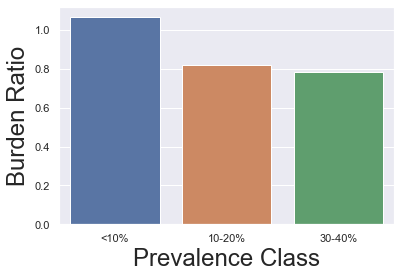

mean 1.0650913702563993
std 0.0008682449450764298
mean 0.8206663763066203
std 0.001950647878138542
mean 0.7835445346766837
std 0.0011168774742535718


In [96]:
df_prev = pd.DataFrame(np.array([prevs, prev_ratios, trials]).T, columns = ['Prevalence Class', 'Burden Ratio', 'Trial'])
df_prev['Burden Ratio'] = df_prev['Burden Ratio'].astype(float)
sns.barplot(data=df_prev, x='Prevalence Class', y='Burden Ratio', errorbar=('ci',95))
plt.show()

In [97]:
for prev_name in prev_names:
    print('mean', df_prev[df_prev['Prevalence Class'] == prev_name]['Burden Ratio'].mean())
    print('std', df_prev[df_prev['Prevalence Class'] == prev_name]['Burden Ratio'].std())


mean 1.0650913702563993
std 0.0008682449450764298
mean 0.8206663763066203
std 0.001950647878138542
mean 0.7835445346766837
std 0.0011168774742535718


In [14]:
dis0_10 = list(finding_stats[finding_stats['Disagreement Rate 0-10%']]['Finding'])
dis10_20 = list(finding_stats[finding_stats['Disagreement Rate 10-20%']]['Finding'])
dis20_30 = list(finding_stats[finding_stats['Disagreement Rate 20-30%']]['Finding'])
dis_list = [dis0_10, dis10_20, dis20_30]
dis_names = ['<10%', '10-20%', '20-30%']
dis_s = []
dis_ratios = []
trials = []

for (dis_class, dis_name) in zip(dis_list, dis_names):
    avg_ratio = 0
    for i in range(10):
        trials.append(i)
        dis_s.append(dis_name)
        ratio = utils.pipeline_comparison(data, 0.8, 0.03, 0.05, dis_class, sig_findings, constants, print_it=False)
        dis_ratios.append(ratio)
        avg_ratio += ratio     
    print(avg_ratio / 10)

1.0433175857008379
0.9242193389388227
0.7847379163590567


<AxesSubplot:xlabel='Disagreement Class', ylabel='Burden Ratio'>

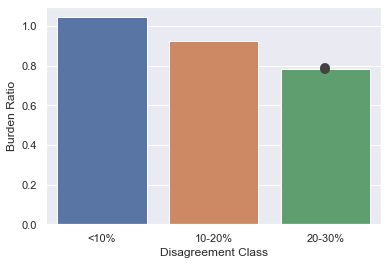

In [15]:
df_dis = pd.DataFrame(np.array([dis_s, dis_ratios, trials]).T, columns = ['Disagreement Class', 'Burden Ratio', 'Trial'])
df_dis['Burden Ratio'] = df_dis['Burden Ratio'].astype(float)
sns.barplot(data=df_dis, x='Disagreement Class', y='Burden Ratio', errwidth=10)


In [99]:
for dis_name in dis_names:
    print('mean', df_dis[df_dis['Disagreement Class'] == dis_name]['Burden Ratio'].mean()*100)
    print('std', df_dis[df_dis['Disagreement Class'] == dis_name]['Burden Ratio'].std()*100)


mean 104.33175857008379
std 0.07587106582434308
mean 92.4219338938823
std 0.18176072633338014
mean 78.47379163590567
std 0.17244649519658733


In [16]:
TPR_f50_70 = list(finding_stats[finding_stats['Diagnostic TPR 0.5-0.7']]['Finding'])
TPR_f70 = list(finding_stats[finding_stats['Diagnostic TPR >0.7']]['Finding'])
TPR_f_list = [TPR_f50_70, TPR_f70]
TPR_f_names = ['50-70%', '>70%']
TPR_fs = []
TPR_f_ratios = []
trials = []

for (TPR_f_class, TPR_f_name) in zip(TPR_f_list, TPR_f_names):
    avg_ratio = 0
    for i in range(10):
        TPR_fs.append(TPR_f_name)
        trials.append(i)
        ratio = utils.pipeline_comparison(data, 0.8, 0.03, 0.05, TPR_f_class, sig_findings, constants, print_it=False)
        TPR_f_ratios.append(ratio)
        avg_ratio += ratio
    #print(avg_ratio / 10)

0.9158413233094027
0.9695293589359792


<AxesSubplot:xlabel='Diagnostic TPR Class', ylabel='Burden Ratio'>

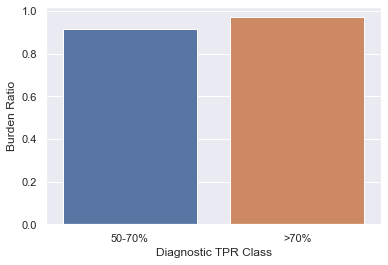

In [17]:
df_TPR_f = pd.DataFrame(np.array([TPR_fs, TPR_f_ratios, trials]).T, columns = ['Diagnostic TPR Class', 'Burden Ratio', 'Trial'])
df_TPR_f['Burden Ratio'] = df_TPR_f['Burden Ratio'].astype(float)
df_TPR_f['Experiment'] = 'Diagnostic TPR'
sns.barplot(data=df_TPR_f, x='Diagnostic TPR Class', y='Burden Ratio', errwidth=10)

In [100]:
for TPR_f_name in TPR_f_names:
    print('mean', df_TPR_f[df_TPR_f['Diagnostic TPR Class'] == TPR_f_name]['Burden Ratio'].mean()*100)
    print('std', df_TPR_f[df_TPR_f['Diagnostic TPR Class'] == TPR_f_name]['Burden Ratio'].std()*100)


mean 91.58413233094026
std 0.09702991104510254
mean 96.95293589359792
std 0.12369836418890001


In [18]:
FPR_f5_15 = list(finding_stats[finding_stats['Diagnostic FPR 0.05-0.15']]['Finding'])
FPR_f15_20 = list(finding_stats[finding_stats['Diagnostic FPR 0.15-0.2']]['Finding'])
FPR_f35_40 = list(finding_stats[finding_stats['Diagnostic FPR 0.35-0.4']]['Finding'])
FPR_f_list = [FPR_f5_15, FPR_f15_20, FPR_f35_40]
FPR_f_names = ['5-15%', '15-20%', '35-40%']
FPR_fs = []
FPR_f_ratios = []
trials = []

for (FPR_f_class, FPR_f_name) in zip(FPR_f_list, FPR_f_names):
    avg_ratio = 0
    for i in range(10):
        FPR_fs.append(FPR_f_name)
        trials.append(i)
        ratio = utils.pipeline_comparison(data, 0.8, 0.03, 0.05, FPR_f_class, sig_findings, constants, print_it=False)
        FPR_f_ratios.append(ratio)
        avg_ratio += ratio
    print(avg_ratio / 10)

0.9360921493421372
0.7684096068825428
0.8193550021105951


<AxesSubplot:xlabel='Diagnostic FPR Class', ylabel='Burden Ratio'>

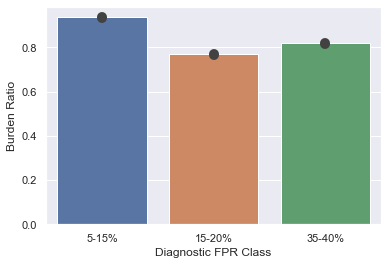

In [19]:
df_FPR_f = pd.DataFrame(np.array([FPR_fs, FPR_f_ratios, trials]).T, columns = ['Diagnostic FPR Class', 'Burden Ratio', 'Trial'])
df_FPR_f['Burden Ratio'] = df_FPR_f['Burden Ratio'].astype(float)
df_FPR_f['Experiment'] = 'Diagnostic FPR'
sns.barplot(data=df_FPR_f, x='Diagnostic FPR Class', y='Burden Ratio', errwidth=10)

In [101]:
for FPR_f_name in FPR_f_names:
    print('mean', df_FPR_f[df_FPR_f['Diagnostic FPR Class'] == FPR_f_name]['Burden Ratio'].mean()*100)
    print('std', df_FPR_f[df_FPR_f['Diagnostic FPR Class'] == FPR_f_name]['Burden Ratio'].std()*100)


mean 93.60921493421372
std 0.1667324878349769
mean 76.84096068825428
std 0.27723744568460384
mean 81.93550021105953
std 0.2761976900515489


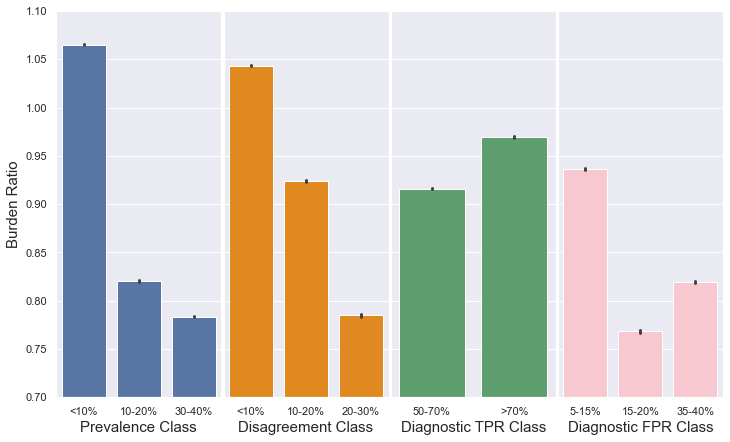

In [145]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 2}
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 6))
#matplotlib.rc('font', **font)
sns.barplot(data=df_prev, x='Prevalence Class', y='Burden Ratio', color='b', errwidth=3, ax=ax1)
sns.barplot(data=df_dis, x='Disagreement Class', y='Burden Ratio', color='darkorange', errwidth=3, ax=ax2)
sns.barplot(data=df_TPR_f, x='Diagnostic TPR Class', y='Burden Ratio', color='g', errwidth=3, ax=ax3)
sns.barplot(data=df_FPR_f, x='Diagnostic FPR Class', y='Burden Ratio', color='pink', errwidth=3, ax=ax4)
for ax in fig.get_axes():
    ax.set_ylim([0.7, 1.1])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    ax.label_outer()
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('Burden_by_class.png', dpi=300)

### Correlation Between Characteristics of Interest
#### At the Continuous Value Level

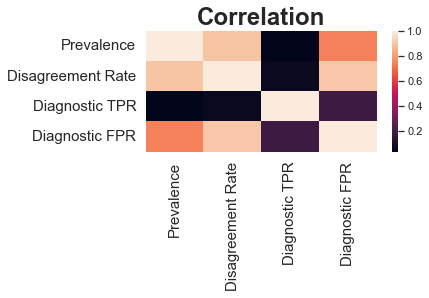

In [103]:
correlation = finding_stats.corr().loc[['Prevalence','Disagreement Rate','Diagnostic TPR', 'Diagnostic FPR'],['Prevalence','Disagreement Rate','Diagnostic TPR', 'Diagnostic FPR']]
sns.heatmap(correlation)
plt.xticks(rotation = 90)
plt.title('Correlation', fontdict={'fontsize': 24})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('Correlation.png', dpi=300)

#### At the Class Level

In [125]:
finding_stats.loc[finding_stats['Prevalence 0-10%']==1,'Prevalence Class']=1
finding_stats.loc[finding_stats['Prevalence 10-20%']==1,'Prevalence Class']=2
finding_stats.loc[finding_stats['Prevalence 30-40%']==1,'Prevalence Class']=3

finding_stats.loc[finding_stats['Disagreement Rate 0-10%']==1,'Disagreement Class']=1
finding_stats.loc[finding_stats['Disagreement Rate 10-20%']==1,'Disagreement Class']=2
finding_stats.loc[finding_stats['Disagreement Rate 20-30%']==1,'Disagreement Class']=3

finding_stats.loc[finding_stats['Diagnostic TPR 0.5-0.7']==1,'Diagnostic TPR Class']=1
finding_stats.loc[finding_stats['Diagnostic TPR >0.7']==1,'Diagnostic TPR Class']=2

finding_stats.loc[finding_stats['Diagnostic FPR 0.05-0.15']==1,'Diagnostic FPR Class']=1
finding_stats.loc[finding_stats['Diagnostic FPR 0.15-0.2']==1,'Diagnostic FPR Class']=2
finding_stats.loc[finding_stats['Diagnostic FPR 0.35-0.4']==1,'Diagnostic FPR Class']=3



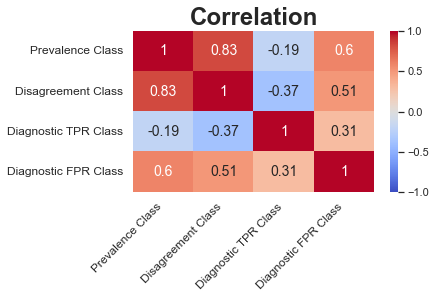

In [138]:
correlation2 = finding_stats.corr().iloc[15::,15::]
sns.heatmap(correlation2, cmap="coolwarm", vmin=-1, vmax=1, annot=True, annot_kws={"size":14})
plt.xticks(rotation = 45, ha='right')
plt.title('Correlation', fontdict={'fontsize': 24})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('Correlation_class.png', dpi=300)

In [117]:
finding_stats

,Finding,Prevalence,Disagreement Rate,Diagnostic TPR,Diagnostic FPR,Prevalence 0-10%,Prevalence 10-20%,Prevalence 30-40%,Disagreement Rate 0-10%,Disagreement Rate 10-20%,Disagreement Rate 20-30%,Diagnostic TPR 0.5-0.7,Diagnostic TPR >0.7,Diagnostic FPR 0.05-0.15,Diagnostic FPR 0.15-0.2,Diagnostic FPR 0.35-0.4,Diagnostic FPR Class,Prevalence Class,Disagreement Class,Diagnostic TPR Class
0,no_finding,0.389157,0.253288,0.549964,0.127943,False,False,True,False,False,True,True,False,True,False,False,1.0,3.0,3.0,1.0
1,cardiomegaly,0.021951,0.018166,0.978448,0.018090,True,False,False,True,False,False,False,True,False,False,False,NaN,1.0,1.0,2.0
2,fracture,0.022046,0.015990,0.914163,0.014416,True,False,False,True,False,False,False,True,False,False,False,NaN,1.0,1.0,2.0
3,lung_lesion,0.007002,0.005204,0.851351,0.004192,True,False,False,True,False,False,False,True,False,False,False,NaN,1.0,1.0,2.0
4,pleural_effusion,0.052985,0.026398,0.832143,0.018483,True,False,False,True,False,False,False,True,False,False,False,NaN,1.0,1.0,2.0
5,pneumothorax,0.012773,0.012300,0.933333,0.011597,True,False,False,True,False,False,False,True,False,False,False,NaN,1.0,1.0,2.0
6,atelectasis,0.055445,0.071530,0.831058,0.065812,True,False,False,True,False,False,False,True,True,False,False,1.0,1.0,1.0,2.0
7,consolidation,0.015990,0.023559,0.976331,0.023558,True,False,False,True,False,False,False,True,False,False,False,NaN,1.0,1.0,2.0
8,pneumonia,0.000946,0.000946,0.000000,0.000000,True,False,False,True,False,False,False,False,False,False,False,NaN,1.0,1.0,NaN
9,edema,0.000757,0.000757,0.625000,0.000473,True,False,False,True,False,False,True,False,False,False,False,NaN,1.0,1.0,1.0
